In [1]:
import os
import re
import glob
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import zarr
import napari
import tifffile
import dask.array as da

from utils.utility_functions import single_channel_pyramid

In [2]:
# I/O
sample = 'CRC-097'

# import Leiden-clustered single-cell data
data = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# read OME-TIFF, segmentation outlines, and H&E channels
tif_path = os.path.join(os.getcwd(), f'input/{sample}_image.ome.tif')
seg_path = os.path.join(os.getcwd(), f'input/{sample}_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), f'input/{sample}_hema_eosin.ome.tif')

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# get markers excluded from analysis
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['markersToExclude']

# import image contrast settings
with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast_limits = yaml.safe_load(f)

# isolate antibodies of interest
abx_channels = [
    i for i in data.columns if 'nucleiRingMask' in i
    if 'Hoechst' not in i if i not in markers_to_exclude
]

# get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

out = os.path.join(os.getcwd(), 'output/S5_crosstalk')
if not os.path.exists(out):
    os.makedirs(out)

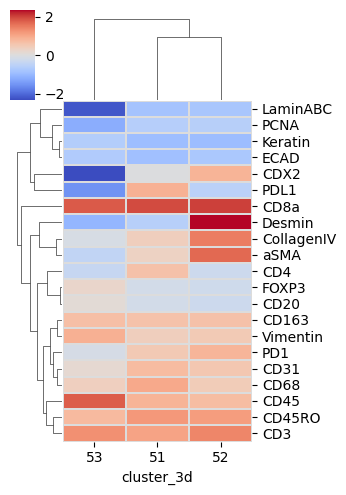

In [3]:
# plot heatmap of cluster5.1, 5.2, and 5.3 mean channel intensities
slice_52 = data[data['emb2'] > 5]
ids_52 = slice_52.index[slice_52['cluster_3d'] == 5]

slice_53 = data[data['emb2'] < -6.88]
ids_53 = slice_53.index[slice_53['cluster_3d'] == 5]

slice_51 = data[(data['emb2'] <= 5) & (data['emb2'] >= -6.88)]
ids_51 = slice_51.index[slice_51['cluster_3d'] == 5]

data.loc[ids_51, 'cluster_3d'] = 51
data.loc[ids_52, 'cluster_3d'] = 52
data.loc[ids_53, 'cluster_3d'] = 53

channels = [
    'cluster_3d', 'CD4_488_nucleiRingMask', 'FOXP3_570_nucleiRingMask', 'CDX2_647_nucleiRingMask',
    'CD8a_660_nucleiRingMask', 'CollagenIV_647_nucleiRingMask', 'Desmin_555_nucleiRingMask',
    'anti_CD45RO_nucleiRingMask', 'CD45_PE_nucleiRingMask', 'anti_CD3_nucleiRingMask',
    'LaminABC_488_nucleiRingMask', 'PD1_647_nucleiRingMask', 'CD20_488_nucleiRingMask',
    'Keratin_570_nucleiRingMask', 'CD31_647_nucleiRingMask', 'Ecad_488_nucleiRingMask',
    'PDL1_647_nucleiRingMask', 'CD68_555_nucleiRingMask', 'CD163_488_nucleiRingMask',
    'PCNA_488_nucleiRingMask', 'Vimentin_555_nucleiRingMask', 'aSMA_660_nucleiRingMask'
]

abx_abbrs = {
    'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin',
    'aSMA_660': 'aSMA','CD4_488': 'CD4', 'CD45_PE': 'CD45',
    'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8a', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3',
    'PDL1_647': 'PDL1', 'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin',
    'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC', 'Desmin_555': 'Desmin',
    'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

clustermap_input = (
    data[channels]
    .groupby('cluster_3d')
    .mean()
)

# compute per channel z-scores across clusters
clustermap_input = (clustermap_input-clustermap_input.mean())/clustermap_input.std()

clustermap_input = clustermap_input.loc[[51, 52, 53]]

# zero-center colorbar
norm = TwoSlopeNorm(vcenter=0, vmin=clustermap_input.min().min(), vmax=clustermap_input.max().max())

g = sns.clustermap(
        clustermap_input.T, xticklabels=1, yticklabels=1, cmap='coolwarm',
        linecolor='gainsboro', linewidth=0.2, figsize=(5, 5), cbar_kws={'shrink': 0.9}
    )

g.ax_heatmap.set_yticklabels(
        [abx_abbrs[i.get_text().split('_nucleiRingMask')[0]] for i in g.ax_heatmap.get_yticklabels()], rotation=0
)

plt.savefig(os.path.join(out, 'clustermap.pdf'))
plt.show()
plt.close('all')

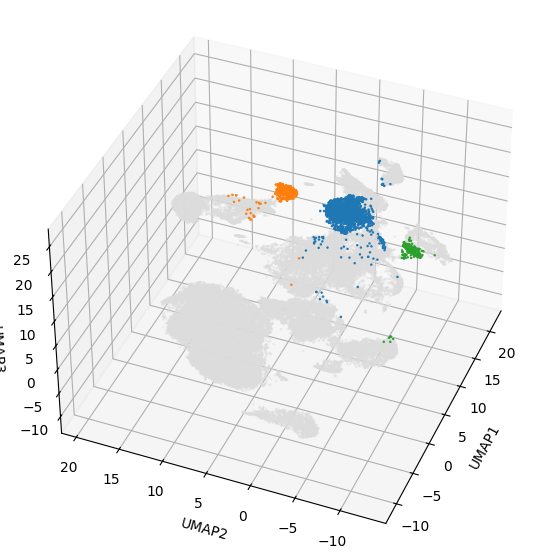

In [12]:
# view clusters 5.1, 5.2, and 5.3 cells in 3D UMAP embedding

data_viz = data.sample(frac=0.05)

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d', computed_zorder=False)
ax.view_init(azim=-158, elev=39)

size = s=150000 / len(data_viz)

ax.scatter(
    data_viz['emb1'], data_viz['emb2'], data_viz['emb3'],
    c='gainsboro', linewidth=0.0, s=size, alpha=0.5,
)
ax.scatter(
    data_viz['emb1'][data_viz['cluster_3d'] == 51],
    data_viz['emb2'][data_viz['cluster_3d'] == 51],
    data_viz['emb3'][data_viz['cluster_3d'] == 51],
    c='tab:blue', linewidth=0.0, s=size, alpha=1,
)
ax.scatter(
    data_viz['emb1'][data_viz['cluster_3d'] == 52],
    data_viz['emb2'][data_viz['cluster_3d'] == 52],
    data_viz['emb3'][data_viz['cluster_3d'] == 52],
    c='tab:orange', linewidth=0.0, s=size, alpha=1,
)
ax.scatter(
    data_viz['emb1'][data_viz['cluster_3d'] == 53],
    data_viz['emb2'][data_viz['cluster_3d'] == 53],
    data_viz['emb3'][data_viz['cluster_3d'] == 53],
    c='tab:green', linewidth=0.0, s=size, alpha=1,
)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')

ax.tick_params(labelsize=10)
ax.grid(True)
plt.savefig(os.path.join(out, 'embedding.png'), dpi=800, bbox_inches='tight')
plt.show()
plt.close('all')

In [5]:
# initialize image viewer
viewer = napari.Viewer()

In [6]:
# loop over antibodies of interest, add them to image viewer, and apply contrast limits
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(
        glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
    )

    viewer.add_image(
        img, rgb=False, blending='additive', colormap='green', visible=False,
        name=ch, contrast_limits=(min, max)
    )

for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    viewer.layers[ch].contrast_limits = (
        contrast_limits[ch][0], contrast_limits[ch][1])

In [7]:
# read segmentation outlines
seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3
)

<Image layer 'segmentation' at 0x109ba33a0>

In [8]:
# add DNA1 channel to image viewer
dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True, opacity=0.8,
    name='DNA1', contrast_limits=(min, max)
)

<Image layer 'DNA1' at 0x16032d640>

In [9]:
# add centroids of cells for each cluster 5 subcluster to image viewer
for c, cluster in zip([[0.12, 0.47, 0.71], [1.0, 0.5, 0.06], [0.17, 0.63, 0.17]], [51, 52, 53]):
    centroids = data[
        ['Y_centroid', 'X_centroid']][data['cluster_3d'] == cluster]
    viewer.add_points(
        centroids, name=f'Cluster{str(cluster)[0]}.{str(cluster)[1]}', face_color=np.array(c), 
        edge_color=np.array(c), edge_width=0.0, size=60.0, opacity=1.0, blending='opaque', visible=True
    ) 

In [10]:
# run image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()